In [1]:
# pip install tscluster

In [2]:
# pip install statsmodels

# Imports

In [3]:
from __future__ import annotations

import time
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

from tscluster.tskmeans import TSKmeans
from tscluster.tsplot import tsplot as tsp

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

import sys
import os

sys.path.append(os.path.abspath('../'))
from codes.utils import gen_synthetic_data
from codes.model.gct_model import GrangeCausalTree
from codes.model.baseline_models import ARTSC, KMW, AggLR
from codes.metrics import calculate_purity, par_set_accuracy

In [4]:
T = 20
N = 60
F = 3

K = 3
entities_per_cluster = N // K

true_set = {0: (0, 1), 1: (0,), 2: (2,)}

feature_noise_sigma = 1
target_noise_sigma = 0.2
n_lags = 2
random_state = 0

ts_arr = gen_synthetic_data(T=T, N=N, F=F, K=K, entities_per_cluster=entities_per_cluster,
                            target_noise_sigma=target_noise_sigma, feature_noise_sigma=feature_noise_sigma,
                            n_lags=n_lags, true_set=true_set, random_state=random_state)

pd.DataFrame(ts_arr[:, :, -1]).describe()


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-1.478315,-6.490654,-0.140834,0.560405,0.776531,-0.446806,-0.615432,-2.364763,-0.261457,5.705720,...,0.435546,-1.644382,1.589326,-0.199603,0.516508,1.400214,-1.247193,0.034684,-2.077517,-1.624552
std,3.015547,2.897579,1.390674,1.913966,1.516712,2.069599,1.188017,2.309849,1.373876,2.940563,...,1.184338,1.527981,1.198328,1.911205,1.196395,1.681389,1.617829,1.204492,2.192017,1.631806
min,-6.717334,-10.470265,-2.824928,-2.434996,-1.982669,-3.930800,-2.286311,-6.737078,-3.075233,0.937943,...,-1.753199,-5.717187,-0.970668,-4.363706,-1.360304,-1.567838,-3.988424,-2.348659,-6.280013,-4.719513
25%,-4.159321,-8.605205,-1.165778,-0.593670,-0.119724,-2.016595,-1.317555,-3.940339,-1.286339,2.662426,...,-0.420451,-2.333691,0.757874,-1.324215,-0.389444,0.082537,-2.122029,-0.911924,-3.823974,-2.592767
50%,-0.987755,-6.731585,-0.261878,0.116815,0.664765,-0.697388,-0.636215,-2.471476,-0.342443,6.707726,...,0.381915,-1.699517,1.524316,0.237234,0.501001,1.947054,-1.277628,0.271919,-1.654969,-1.226247
75%,0.689455,-5.801683,1.067464,1.486865,1.582972,0.863643,0.030377,-0.506949,0.868471,7.533009,...,1.512990,-0.499246,2.413768,1.068962,1.057664,2.504794,-0.040237,0.970770,-0.227401,-0.360976
max,3.312583,0.341276,2.145394,5.253602,4.176113,3.561783,2.888715,1.301190,2.332890,9.438488,...,1.990273,0.910252,3.385899,3.360837,3.719852,4.183268,1.449353,1.926797,0.928080,0.795594


In [5]:
pd.DataFrame(ts_arr[:, 10:20, -1]).describe()

,0,1,2,3,4,5,6,7,8,9
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1.998671,3.073126,0.795488,-1.070133,2.694121,-3.297834,2.200673,0.642868,0.807759,0.178076
std,2.173288,2.426698,2.033385,1.442141,2.887701,2.548479,1.545782,4.625208,1.967835,2.262210
min,-1.942384,-0.966257,-3.390840,-3.511187,-1.722649,-8.384179,-0.285151,-9.068978,-3.343204,-3.937054
25%,0.660469,1.139661,-0.301301,-2.222942,0.598514,-5.042029,1.022459,-0.811379,-0.464435,-0.816650
50%,2.253158,2.515864,0.617476,-0.966448,2.004803,-3.095655,2.077389,0.379465,0.734723,0.231581
75%,3.263101,5.105831,2.388455,-0.310756,4.392533,-0.953805,3.358475,2.543334,2.221867,1.036099
max,7.031149,7.322220,4.183063,1.923391,9.156742,-0.082994,4.687784,9.391813,5.079191,6.393702


In [6]:
ts_arr.shape

(20, 60, 4)

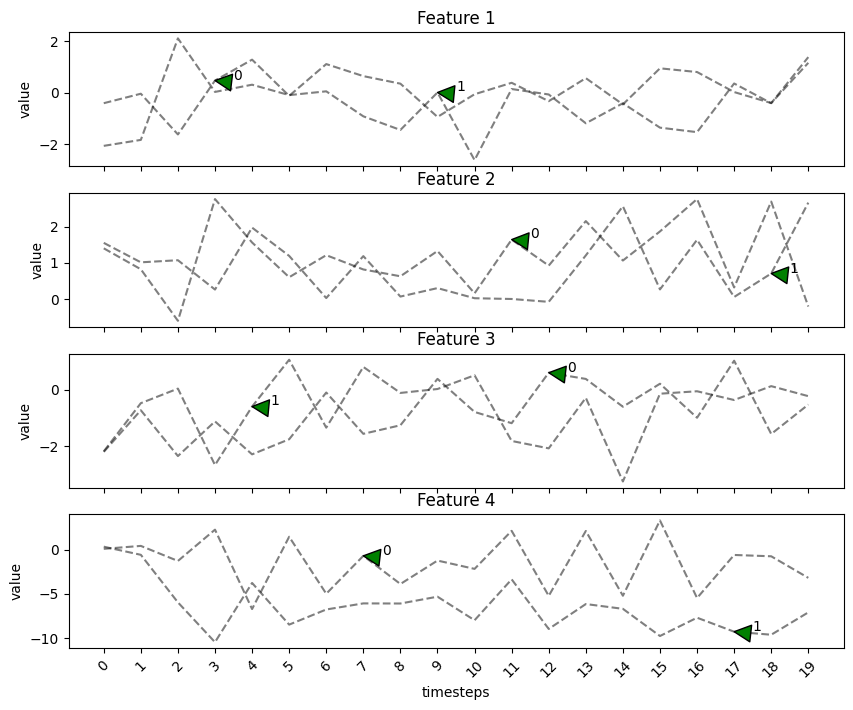

In [7]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[0, 1], show_all_entities=False, figsize=(10, 8))

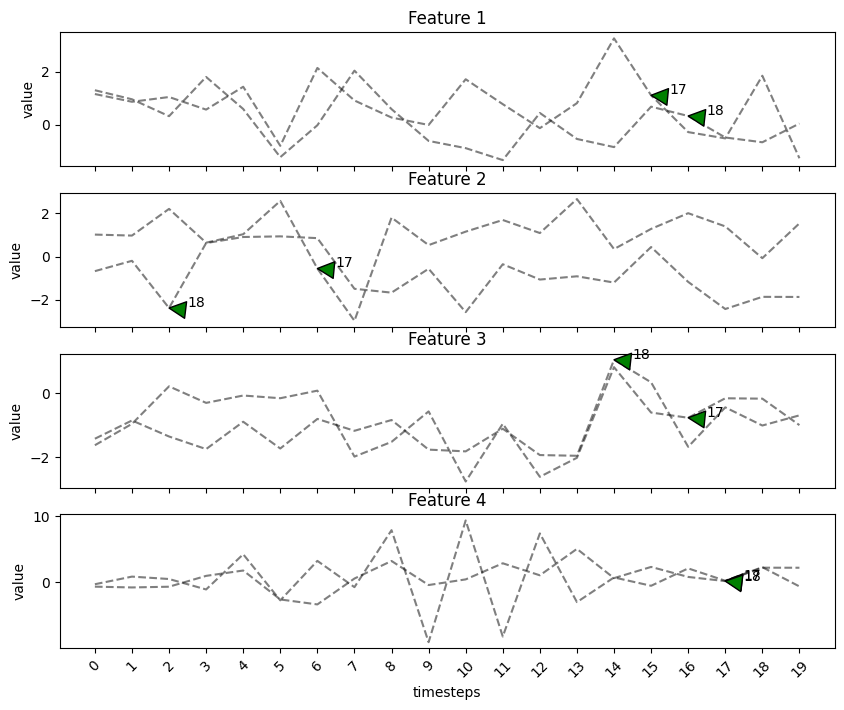

In [8]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[17, 18], show_all_entities=False, figsize=(10, 8))

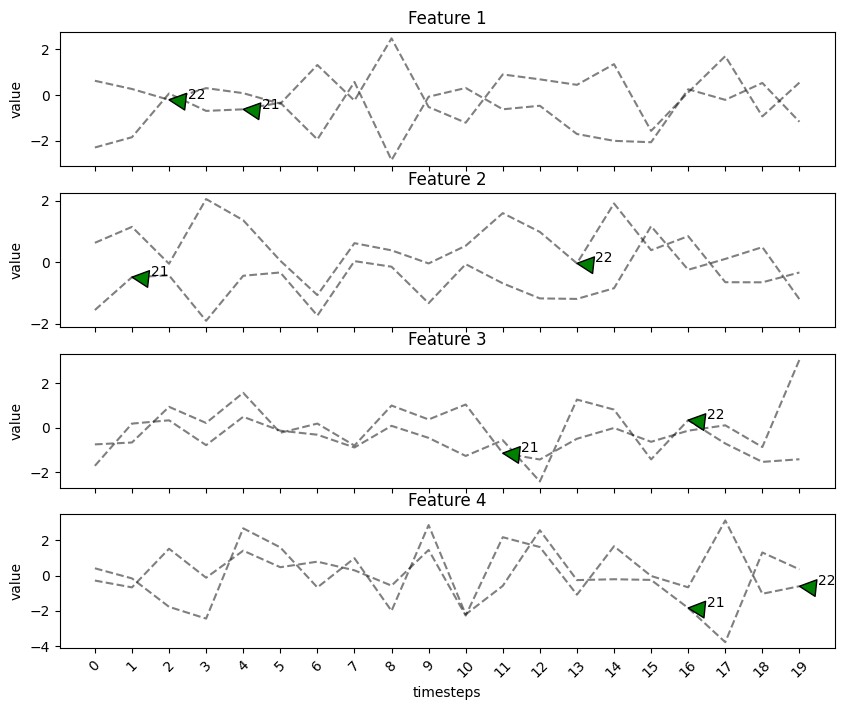

In [9]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[21, 22], show_all_entities=False, figsize=(10, 8))

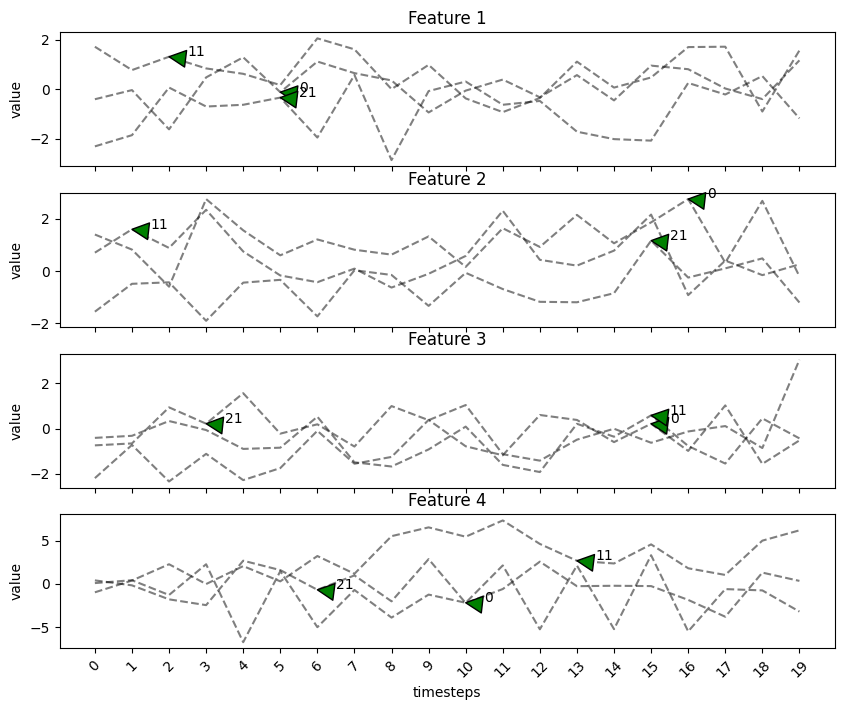

In [10]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[0, 11, 21], show_all_entities=False, figsize=(10, 8))

# Comparison

### Changing target noise

#### Purity Score

In [11]:
K = 4
true_set = {0: (0, ), 1: (0, 1), 2: (1, 2), 3: (0, 1, 2)} # feature 3 is not important at all, target feature is 4
maxlag = 3
N = 80
entities_per_cluster = N // K
F = 4 
T = 50

def get_exp_results(
        noises,
        noise_type,
        K=K, 
        T=T, 
        N=N, 
        F=F, 
        n_lags=maxlag, 
        target_noise_sigma=0,
        par_noise_std=0,
        feature_noise_sigma=1, 
        true_set=true_set, 
        entities_per_cluster=entities_per_cluster, 
        fit_intercept=True,
        random_state=None, 
        is_target_gc=False
        ):
        
    models = ['GC-PTSC', 'GC-PTSC-0.05', 'most_similar_abs_coef', 'clustering_lasso_coef', 'kmeans_b4_modelling_l2'][::-1]
    model_names = ['GCT', 'GCT-0.05', 'KMW', 'Agg-LR', 'AR-TSC'][::-1]

    # par_accuracy_models = ['GC-PTSC', 'GC-PTSC-0.05', 'most_similar_abs_coef', 'clustering_lasso_coef', 'kmeans_b4_modelling_l2'] # 'jrc_lasso',
    # par_accuracy_model_names = [model_names[i] for i in range(len(models)) if models[i] in par_accuracy_models]

    purity = []
    par_acc_score = []
    percent_total_models_used = []
    avg_set_lens = []

     

    counter = 0

    true_labels = np.array(sum([[i]*entities_per_cluster for i in range(K)], start=[]))

    for noise in noises:

        if noise_type == 'target':
            target_noise_sigma = noise 
        elif noise_type == 'par':
            par_noise_std = noise

        ts_arr = gen_synthetic_data(K=K, T=T, N=N, F=F, n_lags=n_lags, target_noise_sigma=target_noise_sigma, 
                                    par_noise_std=par_noise_std, feature_noise_sigma=feature_noise_sigma,
                                    true_set=true_set, entities_per_cluster=entities_per_cluster, 
                                    random_state=random_state, is_target_gc=is_target_gc
                                    )
        
        noise_purity = []
        noise_par_set_acc = []
        avg_set_len = []

        for model in models:

            # rand_gen = np.random.RandomState(0)

            model_results = []
            # try:

            if model == 'kmeans_b4_modelling_l2':
                m = ARTSC(k=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept, metric='euclidean')

                # kmeans_b4_modelling(ts_arr, K=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept,
                #                                             metric='euclidean', verbose=False)
                
            elif model == 'most_similar_abs_coef':
                m = KMW(k=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept, alpha=0.1)
                # labels, theta_us = most_similar_coef(ts_arr, K=K, maxlag=maxlag, verbose=False, random_state=random_state, fit_intercept=fit_intercept,
                #                                      clust_abs_val=True)

            elif model == 'clustering_lasso_coef':
                m = AggLR(k=K, maxlag=maxlag, fit_intercept=fit_intercept, alpha=0.1)
                # labels, theta_us = clustering_lasso_coef(ts_arr, K=K, maxlag=maxlag, fit_intercept=fit_intercept, verbose=False)
                
            elif model == 'GC-PTSC':
                m = GrangeCausalTree(k=K, maxlag=maxlag, fit_intercept=fit_intercept, p_value_threshold=None, lambda_reg=0)
                # labels, theta_us = GC_PTSC(ts_arr, maxlag=maxlag, k=K, p_value_threshold=None)

            elif model == 'GC-PTSC-0.05':
                m = GrangeCausalTree(k=K, maxlag=maxlag, fit_intercept=fit_intercept, p_value_threshold=0.05, lambda_reg=0)
                # labels, theta_us = GC_PTSC(ts_arr, maxlag=maxlag, k=K, p_value_threshold=0.05, use_agg_clustering=False)

            m.fit(ts_arr)
            labels = m.labels_
            theta_us = m.important_feature_set_ 

            if model in ('GC-PTSC', 'GC-PTSC-0.05'):
                avg_set_len.append(np.mean(list(map(lambda j: len(theta_us[j]), labels))))

                if model == 'GC-PTSC':
                    nm, nm_max = m.n_trained_models_
                    percent_total_models_used.append(nm / nm_max)

            # except ValueError: # possibly due to empty cluster
            #     print(f"init {init_} failed for model {model}")
            #     continue

            pur = calculate_purity(true_labels, labels)

            # if model in par_accuracy_models:
            par_acc = par_set_accuracy(true_set=true_set, pred_set=theta_us, true_labels=true_labels, pred_labels=labels)
            # else: 
            #     par_acc = np.nan

            model_results.append((pur, par_acc))

            # if model in ['GC-PTSC', 'clustering_lasso_coef']:
            #     break 
        
            best_idx = np.argmax([res[0] for res in model_results])
            pur, par_acc = model_results[best_idx]
            noise_purity.append(pur)
            
            # if model in par_accuracy_models:
            noise_par_set_acc.append(par_acc)

        purity.append(noise_purity)
        par_acc_score.append(noise_par_set_acc)
        avg_set_lens.append(avg_set_len)

        counter += 1
        print(f"Done with {counter} of {len(noises)}")

    # RSSs = np.array(RSSs)
    purity = np.array(purity)
    par_acc_score = np.array(par_acc_score)
    avg_set_lens = np.array(avg_set_lens)
    percent_total_models_used = np.array(percent_total_models_used)

    return model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used

In [12]:
noises = np.linspace(0, 1, 10)

model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used = get_exp_results(
                                                                                                noises, 
                                                                                                'target', 
                                                                                                random_state=0
                                                                                                )

Done with 1 of 10
Done with 2 of 10
Done with 3 of 10
Done with 4 of 10
Done with 5 of 10
Done with 6 of 10
Done with 7 of 10
Done with 8 of 10
Done with 9 of 10
Done with 10 of 10


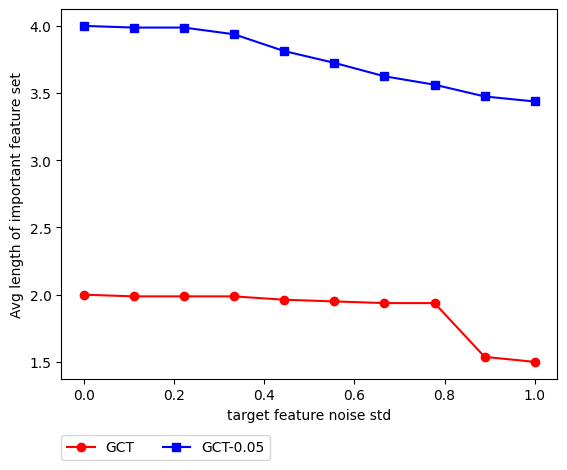

In [13]:
markers = ['o', 's'][::-1]
colors = ['red', 'blue'][::-1]
GCT_models = ['GCT', 'GCT-0.05'][::-1]

fig = plt.figure()
for m in range(len(GCT_models)):
    plt.plot(noises, avg_set_lens[:, m], label=GCT_models[m], marker=markers[m], color=colors[m])

# plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=2, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('Avg length of important feature set')
# plt.title('Avg length of important feature set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('avg_set_len.svg', bbox_inches='tight')
plt.show()

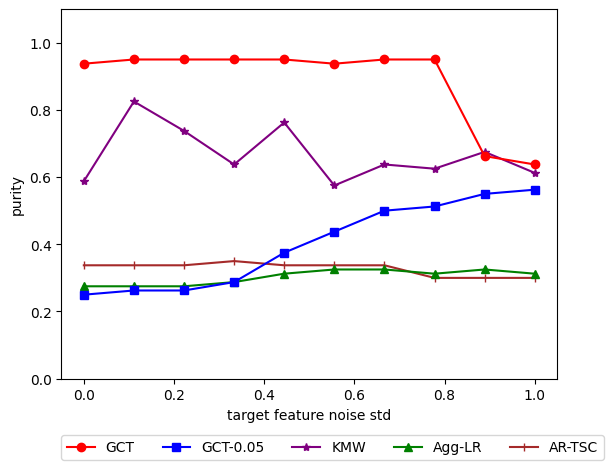

In [14]:
markers = ['o', 's', '*', '^', '|'][::-1]
colors = ['red', 'blue', 'purple', 'green', 'brown'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, purity[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('purity')
# plt.title('Purity vs Std of Noise ($e_i$) added to the Target Feature of each Entity')
plt.savefig('purity.svg', bbox_inches='tight')
plt.show()

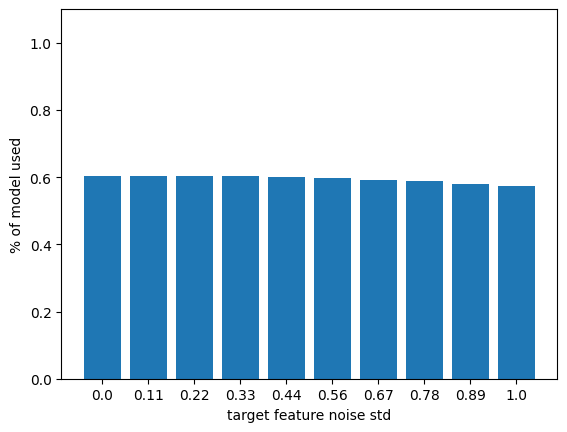

In [15]:
# markers = ['s', '^', 'D', '|', '*'][::-1]

fig = plt.figure()
# for m in range(len(models)):
plt.bar(list(map(str, np.round(noises, 2))), percent_total_models_used)

plt.ylim(0, 1.1)
# plt.legend(loc=(1.01, 0))
plt.xlabel('target feature noise std')
plt.ylabel(r"% of model used")
# plt.title('% of models (trained using GCT) vs Std of Noise added to the Target Feature')
# plt.savefig('percent_model_used.svg', bbox_inches='tight')
plt.show()

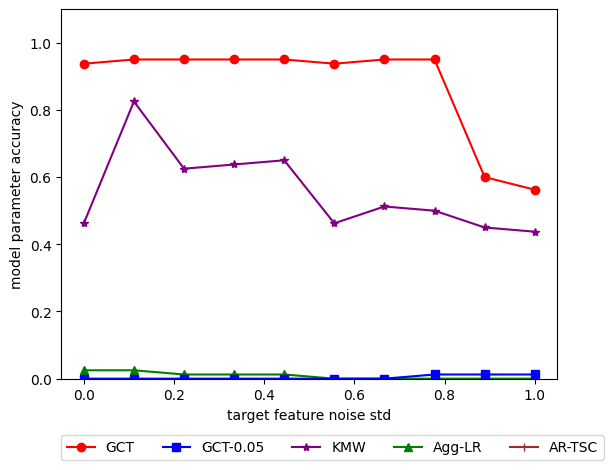

In [16]:
# markers = ['s', '^', '*', '|', '.'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, par_acc_score[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('model parameter accuracy')
# plt.title('Accuracy of important feature set vs Std of Noise ($e_i$) added to the Target Feature of each Entity')
plt.savefig('accuracy_feature_set.svg', bbox_inches='tight')
plt.show()

### Changing par std

#### Purity Score

In [17]:
noises = np.linspace(0, 0.3, 10)

model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used = get_exp_results(
                                                                                                noises, 
                                                                                                'par', 
                                                                                                random_state=0
                                                                                                )

Done with 1 of 10
Done with 2 of 10
Done with 3 of 10
Done with 4 of 10
Done with 5 of 10
Done with 6 of 10
Done with 7 of 10
Done with 8 of 10
Done with 9 of 10
Done with 10 of 10


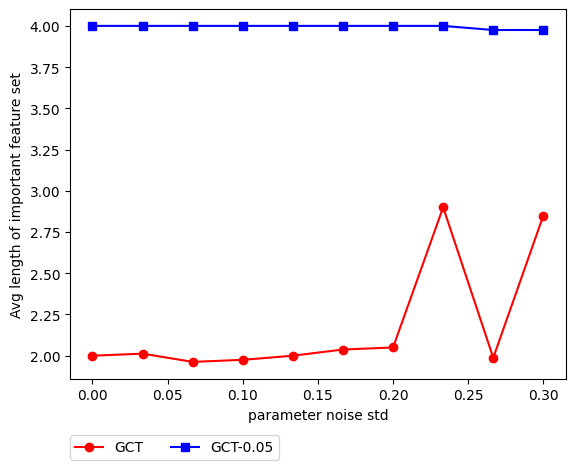

In [18]:
markers = ['o', 's'][::-1]
colors = ['red', 'blue'][::-1]
GCT_models = ['GCT', 'GCT-0.05'][::-1]

fig = plt.figure()
for m in range(len(GCT_models)):
    plt.plot(noises, avg_set_lens[:, m], label=GCT_models[m], marker=markers[m], color=colors[m])

# plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=2, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('Avg length of important feature set')
# plt.title('Avg length of important feature set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('avg_set_len2.svg', bbox_inches='tight')
plt.show()

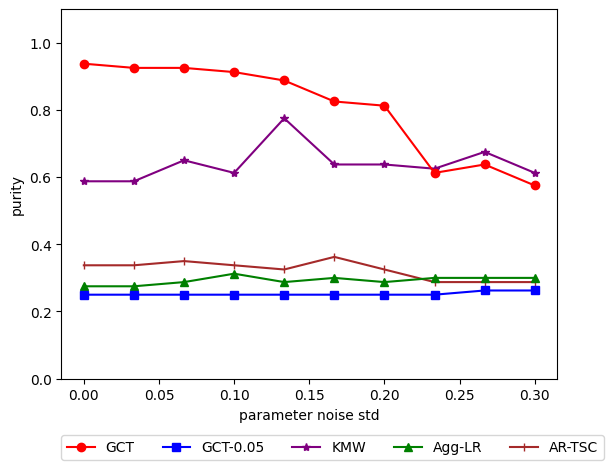

In [19]:
markers = ['o', 's', '*', '^', '|'][::-1]
colors = ['red', 'blue', 'purple', 'green', 'brown'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, purity[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('purity')
# plt.title('Purity vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('purity2.svg', bbox_inches='tight')
plt.show()

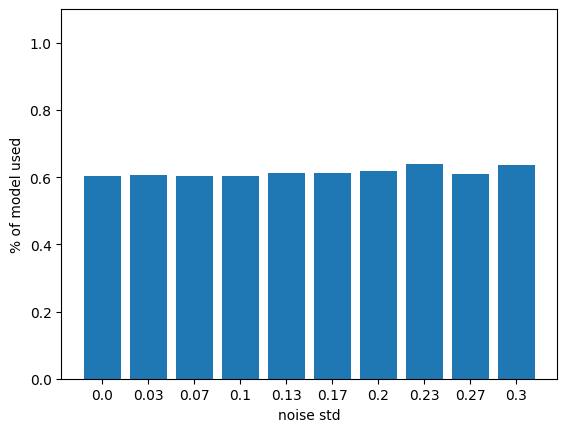

In [20]:
fig = plt.figure()
# for m in range(len(models)):
plt.bar(list(map(str, np.round(noises, 2))), percent_total_models_used)

plt.ylim(0, 1.1)
# plt.legend(loc=(1.01, 0))
plt.xlabel('noise std')
plt.ylabel(r"% of model used")
# plt.title('% of models (trained using GCT) vs Std of Noise added to the Target Feature')
# plt.savefig('percent_model_used_2.svg', bbox_inches='tight')
plt.show()

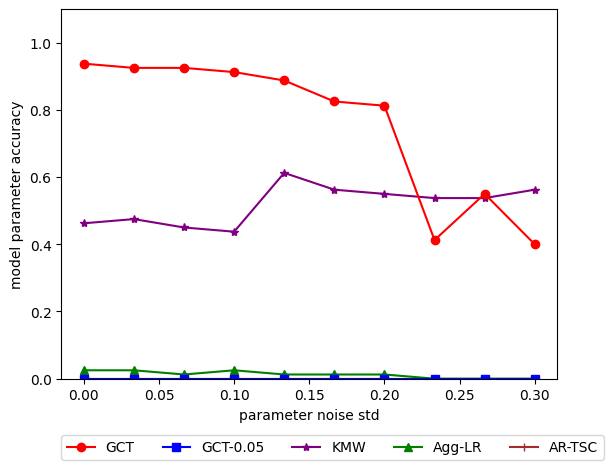

In [21]:
# markers = ['s', '*', '*', '|', '.'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, par_acc_score[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('model parameter accuracy')
# plt.title('Acuracy of Important Feature Set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('accuracy_feature_set2.svg', bbox_inches='tight')
plt.show()